In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. 2D 데이터 불러오기 (sample : 100개) 및 시각화

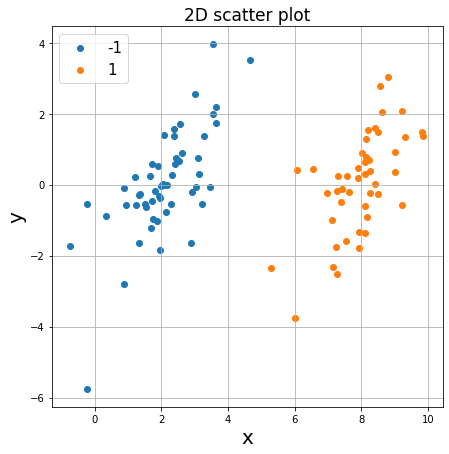

In [336]:
data_csv = pd.read_csv("https://raw.githubusercontent.com/pbharrin/machinelearninginaction/master/Ch06/testSet.txt", delimiter='\t', names=['x', 'y', 'label'])
data_csv.head()

fig, ax = plt.subplots(figsize=(7, 7))


for label in data_csv['label'].unique().tolist():
    if label == 1:
        ax.scatter(data_csv[data_csv['label'] == label]['x'], data_csv[data_csv['label'] == label]['y'], label=label)        
    else :
        ax.scatter(data_csv[data_csv['label'] == label]['x'], data_csv[data_csv['label'] == label]['y'], label=label)       

ax.set_title('2D scatter plot', fontsize=17)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.legend(fontsize=15)
ax.grid(True)
plt.show()

### 2. data  분할 및 module 선언

> 1. 4 개의 프로레스
> 2. 각 프로세스 마다 25개씩 data와 u를 보낸다.
> 3. 각 프로세스에서 병렬로 변수 x 업데이트 (최적 x를 찾음)
> 4. gather 단계 : 각 프로세스로부터 x를 모아, 변수 u 업데이트
> 5. Iteration : 10회

In [340]:
# A SVM example with CVXPY.
from cvxpy import *
import numpy as np
from multiprocessing import Process, Pipe
import time

# Problem dat split!
# Divide the data into NUM_PROCS segments,
# using NUM_PROCS processes.
NUM_PROCS = 4
SPLIT_SIZE = 25
MAX_ITER = 10 # 반복횟수


# np.random.seed(1)
N = NUM_PROCS*SPLIT_SIZE
n = 3

xy_data = [np.array(i).reshape([2,1]) for i in zip(data_csv['x'].values, data_csv['y'].values)]
data = [i for i in zip(data_csv['label'].values, xy_data)]

data_splits = [ex_data[i:i+SPLIT_SIZE] for i in range(0, N, SPLIT_SIZE)]

# Count misclassifications.

def get_error(x):
    error = 0
    for label, sample in data:
        if not label*(np.dot(x[:-1].T, sample) - x[-1])[0] > 0:
            error += 1
    return "%d misclassifications out of %d samples" % (error, N)

# Construct problem.
gamma = 0.13
rho = 1
x = Variable(n)
f = []
for split in data_splits:
    slack = [pos(1 - b*(a.T*x[:-1] - x[-1])) for (b, a) in split]
    f += [norm(x, 2) + gamma*sum(slack)]

# Process:
# Send xi, wait for xbar
def run_process(f, pipe):
    xbar = Parameter(n, value=np.zeros(n))
    u = Parameter(n, value=np.zeros(n))
    f += (rho/2)*sum_squares(x - xbar + u)
    prox = Problem(Minimize(f))
    # ADMM loop.
    while True:
        prox.solve()
        pipe.send(x.value)
        xbar.value = pipe.recv()
        u.value += x.value - xbar.value

### 3. 분산 최적화 시작

In [357]:
# Setup.
pipes = []
procs = []
for i in range(NUM_PROCS):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_process, args=(f[i], remote))]
    procs[-1].start()

w_list = []
# ADMM loop.
for i in range(MAX_ITER):
    # Gather.
    xbar = sum([pipe.recv() for pipe in pipes])/NUM_PROCS
    w_list.append(xbar)
    print(get_error(xbar))
    # Scatter.
    [pipe.send(xbar) for pipe in pipes]

[p.terminate() for p in procs]

35 misclassifications out of 100 samples
13 misclassifications out of 100 samples
1 misclassifications out of 100 samples
0 misclassifications out of 100 samples
0 misclassifications out of 100 samples
0 misclassifications out of 100 samples
0 misclassifications out of 100 samples
0 misclassifications out of 100 samples
0 misclassifications out of 100 samples
0 misclassifications out of 100 samples


[None, None, None, None]

### 4. Iteration 20회 진행하는 동안 wight 변화 

In [358]:
for i,j in enumerate(w_list):
    print("Iteration : {0} 일때 w_1:{1}, w_2:{2}, bias:{3}".format(i+1, round(j[0],3),  round(j[1],3),  round(-j[2],3)))

Iteration : 1 일때 w_1:0.171, w_2:-0.013, bias:-0.311
Iteration : 2 일때 w_1:0.206, w_2:-0.022, bias:-0.578
Iteration : 3 일때 w_1:0.238, w_2:-0.037, bias:-0.829
Iteration : 4 일때 w_1:0.266, w_2:-0.066, bias:-1.053
Iteration : 5 일때 w_1:0.289, w_2:-0.091, bias:-1.212
Iteration : 6 일때 w_1:0.311, w_2:-0.11, bias:-1.341
Iteration : 7 일때 w_1:0.321, w_2:-0.116, bias:-1.412
Iteration : 8 일때 w_1:0.325, w_2:-0.12, bias:-1.466
Iteration : 9 일때 w_1:0.329, w_2:-0.124, bias:-1.495
Iteration : 10 일때 w_1:0.329, w_2:-0.124, bias:-1.499


### Iteration : 0 ~ 9의 Hyperplane 시각화

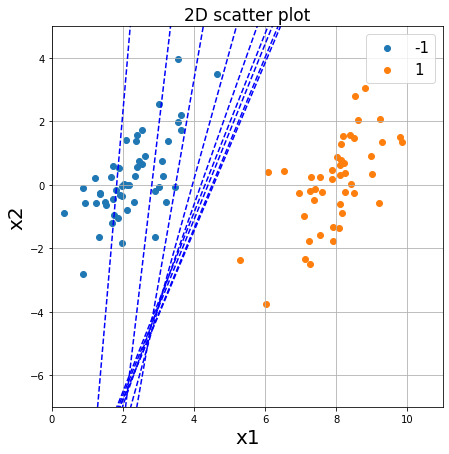

In [379]:
fig, ax = plt.subplots(figsize=(7, 7))

for label in data_csv['label'].unique().tolist():
    if label == 1:
        ax.scatter(data_csv[data_csv['label'] == label]['x'], data_csv[data_csv['label'] == label]['y'], label=label)        
    else :
        ax.scatter(data_csv[data_csv['label'] == label]['x'], data_csv[data_csv['label'] == label]['y'], label=label)       

# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.

for i in w_list[:-1]:
    w = np.array([i[0], i[1]])
    a = -i[0] / i[1]
    xx = np.linspace(-2,12)
    yy = a * xx - (-i[2]) /i[1]

    margin = 1 / np.sqrt(np.sum(np.array([[i[0], i[1]]]) ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    ax.plot(xx, yy, 'k--',  color='blue')
#     ax.plot(xx, yy_down, 'k--', color='red')
#     ax.plot(xx, yy_up, 'k--',  color='red')



x_min = -4.8
x_max = 4.2
y_min = -6
y_max = 6

ax.set_xlim(0, 11)
ax.set_ylim(-7, 5)

ax.set_title('2D scatter plot', fontsize=17)
ax.set_xlabel('x1', fontsize=20)
ax.set_ylabel('x2', fontsize=20)
ax.legend(fontsize=15)
ax.grid(True)
plt.show()

### Iteration 10의 hyperplane 및 margin 시각화

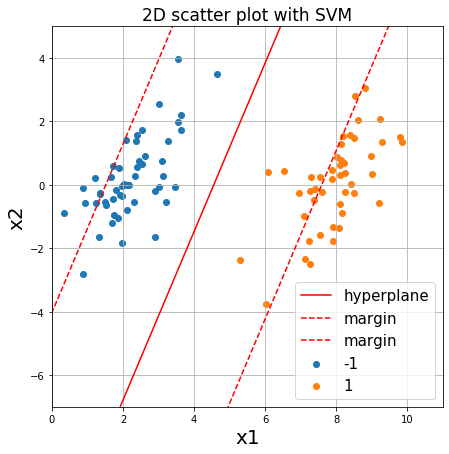

In [380]:
fig, ax = plt.subplots(figsize=(7, 7))

for label in data_csv['label'].unique().tolist():
    if label == 1:
        ax.scatter(data_csv[data_csv['label'] == label]['x'], data_csv[data_csv['label'] == label]['y'], label=label)        
    else :
        ax.scatter(data_csv[data_csv['label'] == label]['x'], data_csv[data_csv['label'] == label]['y'], label=label)       

# get the separating hyperplane
w = np.array([xbar[0], xbar[1]])
a = -w[0] / w[1]
xx = np.linspace(-2,12)
yy = a * xx - (-xbar[2]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.

margin = 1 / np.sqrt(np.sum(np.array([[xbar[0], xbar[1]]]) ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
ax.plot(xx, yy, 'k-',  color='red', label='hyperplane')
ax.plot(xx, yy_down, 'k--', color='red', label='margin')
ax.plot(xx, yy_up, 'k--',  color='red', label='margin')

x_min = -4.8
x_max = 4.2
y_min = -6
y_max = 6

ax.set_xlim(0, 11)
ax.set_ylim(-7, 5)

ax.set_title('2D scatter plot with SVM', fontsize=17)
ax.set_xlabel('x1', fontsize=20)
ax.set_ylabel('x2', fontsize=20)
ax.legend(fontsize=15)
ax.grid(True)
plt.show()